In [1]:
# jute_fiber_classification.py

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
os.listdir("/kaggle/input/jute-fiber-variety/Jute Variety Dataset")

2025-05-11 08:44:43.773341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746953083.980152      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746953084.040136      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['Mesta', 'Kenaf', 'Bangladeshi_White', 'Tossa']

In [2]:

!pip install -q efficientnet
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [3]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 32
default_image_size = tuple((122,122))
image_size = 0
width=122
height=122
depth=3

In [4]:
import os
import shutil
from pathlib import Path

# Define original root dataset path and new merged path
root_path = Path("/kaggle/input/jute-fiber-variety/Jute Variety Dataset")
merged_path = Path("/kaggle/working/jute_merged")
merged_path.mkdir(exist_ok=True)

# Loop through each variety (e.g., white, mesta)
for variety_folder in root_path.iterdir():
    if variety_folder.is_dir():
        variety_name = variety_folder.name
        target_folder = merged_path / variety_name
        target_folder.mkdir(exist_ok=True)

        # Inside each variety folder: white_microscope, white_smartphone
        for subfolder in variety_folder.iterdir():
            if subfolder.is_dir():
                for img_file in subfolder.glob("*.*"):
                    if img_file.is_file():
                        shutil.copy(img_file, target_folder / img_file.name)

print("✅ Dataset restructuring complete. Now ready for splitfolders.")


✅ Dataset restructuring complete. Now ready for splitfolders.


In [5]:
import os
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
from os import listdir



# Path to your dataset
directory_root = '/kaggle/working/jute_merged' 

# Function to convert image to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Load images and labels
image_list, label_list, directory_list = [], [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir:
        if directory == ".DS_Store":
            continue  # skip system file

        print(f"[INFO] Processing {directory} ...")
        files = listdir(os.path.join(directory_root, directory))
        
        for file in files:
            if file == ".DS_Store":
                continue

            image_path = os.path.join(directory_root, directory, file)
            if image_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_array = convert_image_to_array(image_path)
                if image_array is not None and image_array.size > 0:
                    image_list.append(image_array)
                    label_list.append(directory)
                    directory_list.append(image_path)
            else:
                print(f"[WARN] Skipped: {image_path}")

    print("[INFO] Image loading completed")

except Exception as e:
    print(f"[ERROR] {e}")


[INFO] Loading images ...
[INFO] Processing Bangladeshi_White ...
[INFO] Processing Mesta ...
[INFO] Processing Tossa ...
[INFO] Processing Kenaf ...
[INFO] Image loading completed


In [6]:
import pickle
from sklearn.preprocessing import LabelBinarizer
# Step 3: Encode labels and save transformer
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
with open("label_transform.pkl", "wb") as f:
    pickle.dump(label_binarizer, f)
n_classes = len(label_binarizer.classes_)
print(f"[INFO] Classes: {label_binarizer.classes_}")

# Step 4: Normalize images and split dataset
np_image_list = np.array(image_list, dtype=np.float32) / 255.0
print("[INFO] Splitting data to train/test ...")
x_train, x_test, y_train, y_test = train_test_split(
    np_image_list, image_labels, test_size=0.1, random_state=42
)
print(f"[INFO] Train shape: {x_train.shape}, Test shape: {x_test.shape}")

# Step 5: Data augmentation
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode="nearest"
)

print("✅ Preprocessing pipeline complete. Ready for model training.")

[INFO] Classes: ['Bangladeshi_White' 'Kenaf' 'Mesta' 'Tossa']
[INFO] Splitting data to train/test ...
[INFO] Train shape: (4415, 122, 122, 3), Test shape: (491, 122, 122, 3)
✅ Preprocessing pipeline complete. Ready for model training.


In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import plotly.graph_objects as go
# === Callbacks ===
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.0001,
        patience=30,
        mode="auto",
        verbose=1 )
]
# === Custom Metrics ===
def recall_m(y_true, y_pred):
    y_true_float = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true_float * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_float, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true_float = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true_float * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# === Training Curve Plot ===
def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(1, len(training) + 1), y=training, mode='lines+markers', name="Train", marker=dict(color="dodgerblue")))
    fig.add_trace(go.Scatter(x=np.arange(1, len(validation) + 1), y=validation, mode='lines+markers', name="Val", marker=dict(color="darkorange")))
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

# === Evaluate, Plot, and Save Model ===
def Res_Plot_Test_Save(model, name, x_test, y_test):
    print("[INFO] Calculating model accuracy ...")
    scores = model.evaluate(x_test, y_test)
    print(f"✅ Test Accuracy: {scores[1] * 100:.2f}%")

    print("[INFO] Saving model ...")
    model.save(name)
    print(f"✅ Model saved as {name}")

In [8]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers, models

base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(122, 122, 3))
base_model.trainable = False # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1746953583.682532      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=my_callbacks)

# Evaluate the model
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Save the model
model.save('jute_fiber_classifier.h5')

Epoch 1/50


I0000 00:00:1746953622.043794     105 service.cc:148] XLA service 0x7c2204002250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746953622.044932     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746953625.644777     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/137 ━━━━━━━━━━━━━━━━━━━━ 2:05:48 56s/step - accuracy: 0.3125 - loss: 1.3932

I0000 00:00:1746953644.857513     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 110s 400ms/step - accuracy: 0.3264 - loss: 1.3648 - val_accuracy: 0.4236 - val_loss: 1.2584
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4375 - loss: 1.2991 - val_accuracy: 0.4114 - val_loss: 1.2578
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.3572 - loss: 1.3156 - val_accuracy: 0.4236 - val_loss: 1.2427
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 1.1819 - val_accuracy: 0.4358 - val_loss: 1.2400
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.3682 - loss: 1.3077 - val_accuracy: 0.4094 - val_loss: 1.2430
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.1817 - val_accuracy: 0.4134 - val_loss: 1.2421
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.4010 - loss: 1.2656 - val_accuracy: 0.4379 - val_loss: 1.2247
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.2629 - val_accuracy: 0

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Get predicted class labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'/'micro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


In [10]:
def build_convnext_model():
    base_model = ConvNeXtBase(include_top=False, weights="imagenet",input_shape=(122, 122, 3))
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", precision_m, recall_m, f1_m])
    return model
# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=my_callbacks
)

# Evaluate the model
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Save the model
model.save('jute_fiber_classifier.h5')


Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.4464 - loss: 1.2060 - val_accuracy: 0.5031 - val_loss: 1.1430
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.9375 - val_accuracy: 0.4969 - val_loss: 1.1443
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.4418 - loss: 1.2110 - val_accuracy: 0.5112 - val_loss: 1.1181
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 1.1034 - val_accuracy: 0.4990 - val_loss: 1.1199
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.4450 - loss: 1.2033 - val_accuracy: 0.4745 - val_loss: 1.1714
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 1.0116 - val_accuracy: 0.4847 - val_loss: 1.1624
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.4510 - loss: 1.1950 - val_accuracy: 0.5275 - val_loss: 1.0974
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.1709 - val_

In [11]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')



In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Get predicted class labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'/'micro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 764ms/step
Precision: 0.5389
Recall:    0.4745
F1 Score:  0.4400
Accuracy:  0.4745


In [29]:
import torch
import torch.nn as nn
import timm
from torch.optim import Adam

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define number of classes
num_classes = n_classes  # Replace this with actual number

# Create the model
model = timm.create_model(
    'vit_base_patch16_224',   # Equivalent to 'vit_b16_imagenet1k'
    pretrained=True,
    num_classes=num_classes
).to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Summary of model (optional)
print(model)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [30]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


NameError: name 'test_loader' is not defined

In [28]:
!pip install -U keras-cv
import keras_cv

from keras_cv.models import DeiTClassifier
from tensorflow.keras import layers, models

# Assuming you have keras_cv installed
model = DeiTClassifier.from_preset(
    'deit_base_distilled_patch16_224',
    num_classes=n_classes,
    input_shape=(224, 224, 3)
)

# Train for a few epochs
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all except last 20 layers
    layer.trainable = False


ImportError: cannot import name 'DeiTClassifier' from 'keras_cv.models' (/usr/local/lib/python3.11/dist-packages/keras_cv/api/models/__init__.py)

In [23]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks (using your existing my_callbacks if you prefer)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
callbacks = [early_stopping]  # You can add your my_callbacks here

# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Evaluate the model
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Optionally, you can save the model
model.save('deit_jute_classifier.h5')





TypeError: compile() got an unexpected keyword argument 'optimizer'

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Get predicted class labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'/'micro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


In [32]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers, models

base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(122, 122, 3))
base_model.trainable =  True 
for layer in base_model.layers[:-10]:  # Freeze all except last 20 layers
    layer.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
y_int = y_train.argmax(axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights))
print("✅ Class weights:", class_weights)

✅ Class weights: {0: 0.9539757994814174, 1: 1.0971669980119285, 2: 0.9606179286335944, 3: 1.0006799637352675}


In [33]:
# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS,),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=my_callbacks)

# Evaluate the model
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Save the model
model.save('jute_fiber_classifier.h5')

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 384ms/step - accuracy: 0.3430 - loss: 1.3689 - val_accuracy: 0.4155 - val_loss: 1.2493
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4062 - loss: 1.3079 - val_accuracy: 0.4216 - val_loss: 1.2364
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.4168 - loss: 1.2607 - val_accuracy: 0.4827 - val_loss: 1.1412
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.4191 - val_accuracy: 0.4562 - val_loss: 1.1586
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.4173 - loss: 1.2262 - val_accuracy: 0.4929 - val_loss: 1.1376
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.2125 - val_accuracy: 0.4786 - val_loss: 1.1455
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.4455 - loss: 1.1987 - val_accuracy: 0.4908 - val_loss: 1.0903
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.2779 - val

In [ ]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Get predicted class labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'/'micro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 691ms/step
Precision: 0.6319
Recall:    0.6110
F1 Score:  0.5985
Accuracy:  0.6110


In [36]:
def build_mobilenetv3_model():
    base_model = MobileNetV3Large(include_top=False, weights="imagenet", input_shape=(122,122,3))
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", precision_m, recall_m, f1_m])
    return model


In [37]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=my_callbacks
)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 79s 274ms/step - accuracy: 0.5509 - loss: 0.9946 - val_accuracy: 0.6538 - val_loss: 0.8542
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7188 - loss: 0.9536 - val_accuracy: 0.6578 - val_loss: 0.8607
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.5596 - loss: 1.0128 - val_accuracy: 0.6375 - val_loss: 0.8931
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5312 - loss: 1.1264 - val_accuracy: 0.6314 - val_loss: 0.8990
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.5590 - loss: 1.0127 - val_accuracy: 0.6456 - val_loss: 0.8212
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.0261 - val_accuracy: 0.6456 - val_loss: 0.8311
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.5646 - loss: 1.0069 - val_accuracy: 0.6782 - val_loss: 0.7981
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 1.0088 - val_

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Get predicted class labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'/'micro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Precision: 0.7086
Recall:    0.7108
F1 Score:  0.7087
Accuracy:  0.7108


In [50]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


input_shape = (122,122, 3)


base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze base model
base_model.trainable = False

# Build head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.32)(x)  # Prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(n_classes, activation='softmax')(x)  # Multi-class output

model = Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 122, 122, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 4, 4, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,857,220 (224.52 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [53]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=60,
    class_weight=class_weights
)


Epoch 1/60


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')

# Evaluate the model on the test set
evaluation = model.evaluate(x_test, y_test, verbose=0)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Get predicted class labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'/'micro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


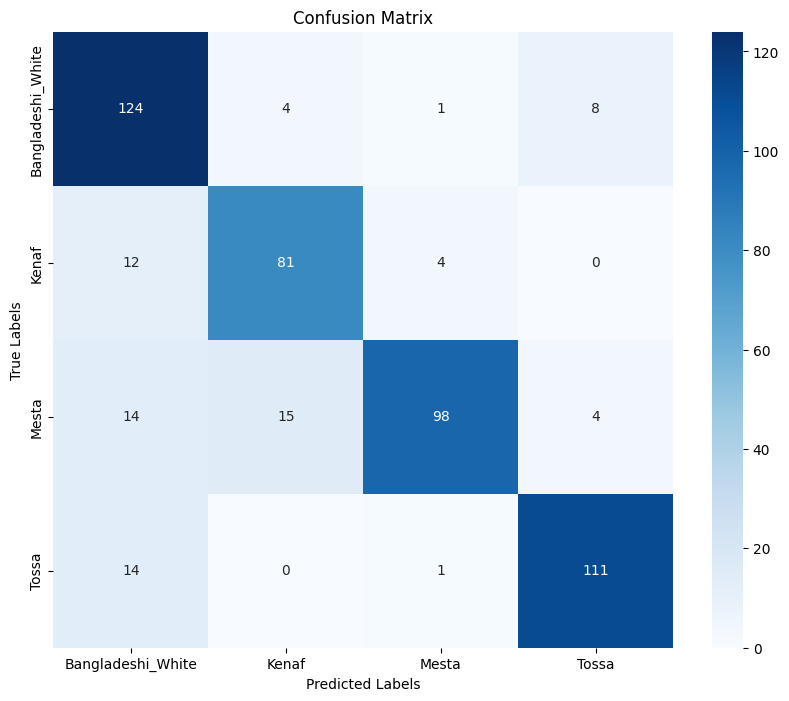


[INFO] Classification Report:

                   precision    recall  f1-score   support

Bangladeshi_White       0.76      0.91      0.82       137
            Kenaf       0.81      0.84      0.82        97
            Mesta       0.94      0.75      0.83       131
            Tossa       0.90      0.88      0.89       126

         accuracy                           0.84       491
        macro avg       0.85      0.84      0.84       491
     weighted avg       0.85      0.84      0.84       491


[INFO] Overall Accuracy: 84.32%


In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_binarizer.classes_  # Or use your list of class names

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\n[INFO] Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Overall accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n[INFO] Overall Accuracy: {acc * 100:.2f}%")


In [44]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (122, 122, 3)

# Load ResNet101V2 base
base_model = ResNet101V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze base model layers for initial training
base_model.trainable = False

# Add custom top layers
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(n_classes, activation='softmax')(x)  # Adjust n_classes

# Final model
model = Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

# Train
history = model.fit(
    aug.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=70,
    class_weight=class_weights
)


171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 122, 122, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101v2 (Functional)             │ (None, 4, 4, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,152,132 (164.61 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

Epoch 1/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.3282 - loss: 1.7530 - val_accuracy: 0.5255 - val_loss: 1.0796
Epoch 2/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.4803 - loss: 1.2728 - val_accuracy: 0.5906 - val_loss: 0.9764
Epoch 3/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.5011 - loss: 1.1646 - val_accuracy: 0.6334 - val_loss: 0.8958
Epoch 4/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.5512 - loss: 1.0521 - val_accuracy: 0.6599 - val_loss: 0.8461
Epoch 5/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.6048 - loss: 0.9655 - val_accuracy: 0.6558 - val_loss: 0.8264
Epoch 6/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.6136 - loss: 0.9276 - val_accuracy: 0.6904 - val_loss: 0.7839
Epoch 7/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.6198 - loss: 0.9121 - val_accuracy: 0.6945 - val_loss: 0.7606
Epoch 8/70
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.6509 - loss: 0.835

In [45]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')

# Evaluate the model on the test set
evaluation = model.evaluate(x_test, y_test, verbose=0)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")

Test Loss: 0.4355
Test Accuracy: 84.32%


In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Get predicted class labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'/'micro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 487ms/step
Precision: 0.8468
Recall:    0.8432
F1 Score:  0.8426
Accuracy:  0.8432


/kaggle/working/jute_merged/Bangladeshi_White/Bangladeshi_White_Microscope121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


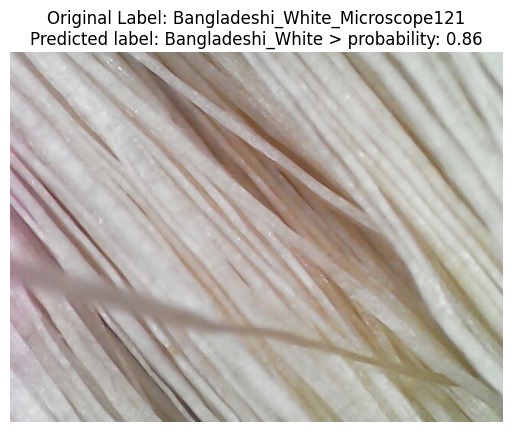

In [48]:
from random import randint

image_dir= "/kaggle/working/jute_merged/Bangladeshi_White/Bangladeshi_White_Microscope121.jpg"
print(image_dir)
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
# print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


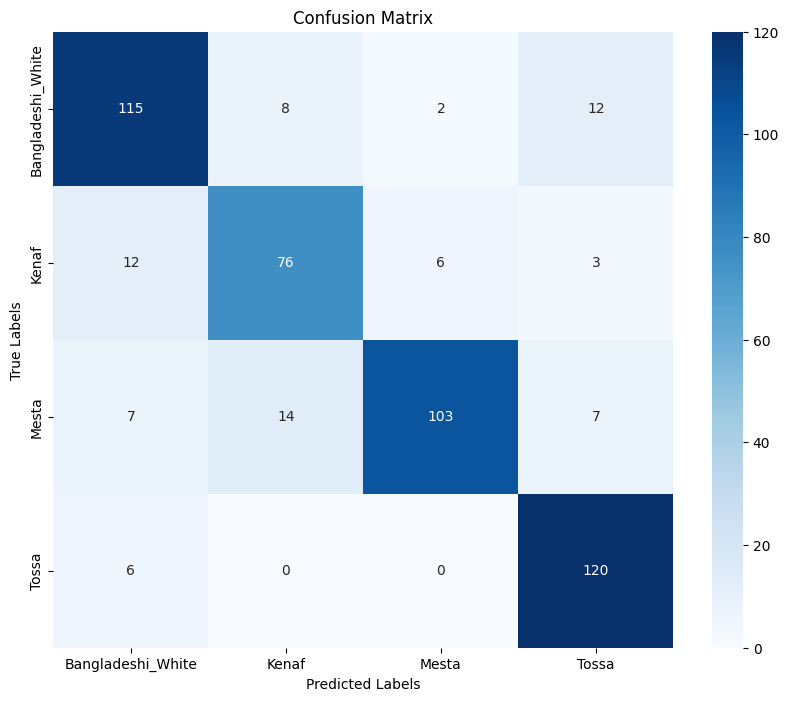


[INFO] Classification Report:

                   precision    recall  f1-score   support

Bangladeshi_White       0.82      0.84      0.83       137
            Kenaf       0.78      0.78      0.78        97
            Mesta       0.93      0.79      0.85       131
            Tossa       0.85      0.95      0.90       126

         accuracy                           0.84       491
        macro avg       0.84      0.84      0.84       491
     weighted avg       0.85      0.84      0.84       491


[INFO] Overall Accuracy: 84.32%


In [47]:

# Predict class probabilities
y_pred_probs = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_binarizer.classes_  # Or use your list of class names

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\n[INFO] Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Overall accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n[INFO] Overall Accuracy: {acc * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


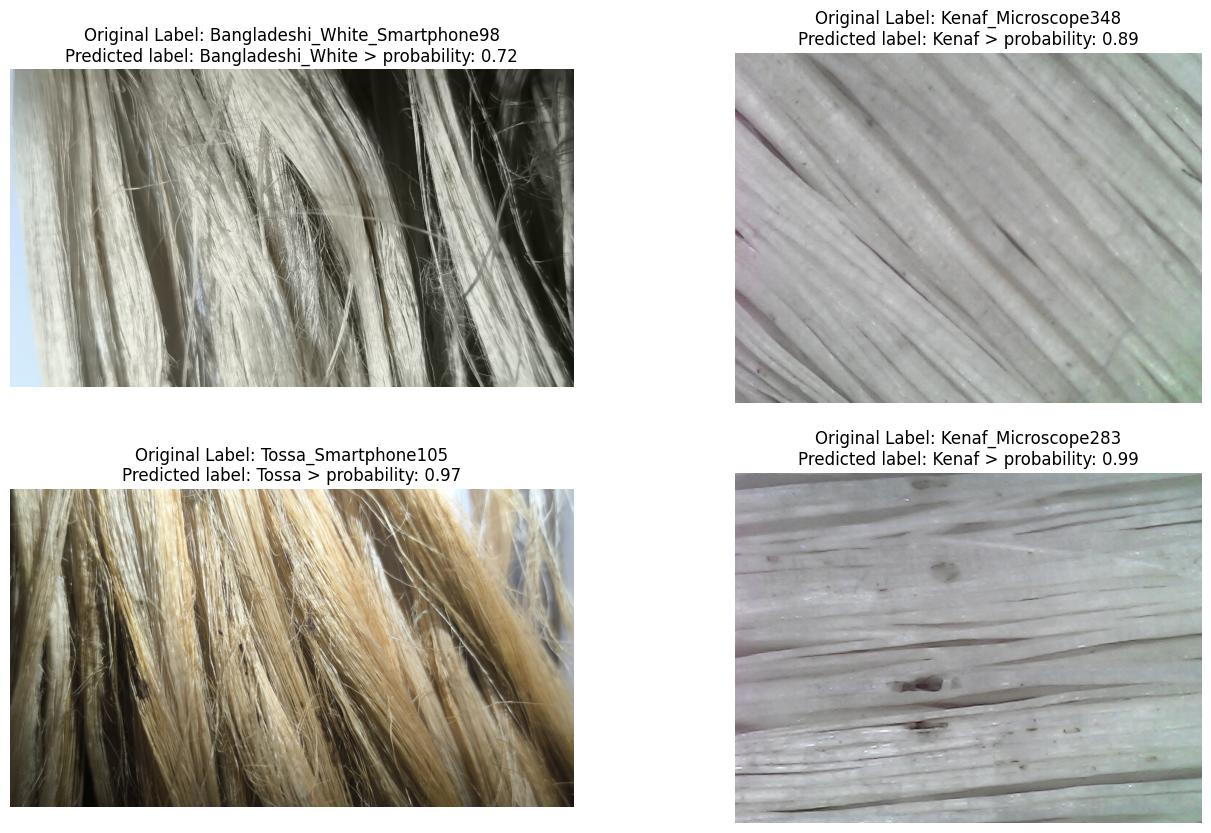

In [49]:
# create figure
fig = plt.figure(figsize=(16, 10))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image2 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image2)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image3 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image3)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image4 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image4)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()